In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import random
from heapq import heappop, heappush

In [2]:
from MAPF import Map
from MAPF import read_map_from_movingai_file, read_tasks_from_movingai_file

In [3]:
from PC_CBS import PC_CBS

Final cost 141,
Euclidean cost 140


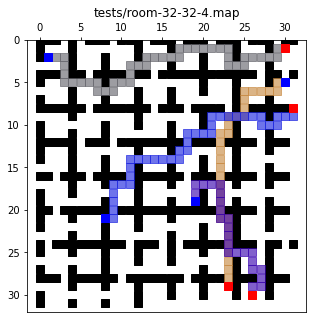

In [4]:
# Один тест CBS

map_file = 'tests/room-32-32-4.map'
scen_file = 'tests/scen-even/room-32-32-4-even-19.scen'


w, h, cells = read_map_from_movingai_file(map_file)
tasks = read_tasks_from_movingai_file(scen_file)

task_map = Map()
task_map.SetGridCells(w, h, cells)

num = 4

Starts = [(item[0], item[1]) for item in tasks[2:num+2]]
Goals = [(item[2], item[3]) for item in tasks[2:num+2]]

result = PC_CBS(task_map, Starts, Goals)

if result[0]:
    print(f'Final cost {result[1].g},\nEuclidean cost {sum([tasks[i][-1] for i in range(num)])}')
    
    obs_x = []
    obs_y = []

    for y, cell_y in enumerate(task_map.cells):
        for x, cell_x in enumerate(cell_y):
            if cell_x == 1:
                obs_x.append(x)
                obs_y.append(y)
            
    x = np.array(obs_x)
    y = np.array(obs_y)

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    ax.set_ylim(task_map.height, 0)
    ax.xaxis.set_ticks_position('top')

    ax.scatter(x, y, c='black', marker='s', s=50)
    ax.set_facecolor('white')
    ax.set_title(map_file)

    color = ["#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)]) + ''.join(['A', '0'])
             for i in range(num)]

    for a in result[1].sol:
        path = result[1].sol[a]
        x = []
        y = []
        for node in path:
            x.append(node.i)
            y.append(node.j)
        ax.scatter(x[1:-1], y[1:-1], c=color[a], marker='s', s=50)
        ax.scatter(x[:1], y[:1], c='blue', marker='s', s=50)
        ax.scatter(x[-1:], y[-1:], c='red', marker='s', s=50)

    plt.show()